# Homework 2
This notebook represent the resolution of the homework 2 given in the Applied Data Analyse course. The Homework github is  https://github.com/epfl-ada/ADA2017-Homeworks/tree/master/02%20-%20Data%20from%20the%20Web


The description of the problem can be seen in the refered link above.

## Table of Content
1. Resolution
2. Extraction
3. Answers of the assignments
4. Merge
5. Plot and Discussion

## Resolution

We first import all the library we need.

In [29]:
import requests # Used to send http request and thread http responses.
from bs4 import BeautifulSoup  # Used to parse the html file and extract choosen information.
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Extraction

This section present the method that we used to extract the wanted information from html files.

The two websites are using json files as document model to create the ranking and to have the information of the universities. So by analysing the all the networks request and responses through `firefox` browser network tools, we find the url that responses the json files. 

In [30]:
tu_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508326775940'
th_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# Get the json files, the stored data structure are dictionnaries.
json_tu = requests.get(tu_URL).json()  
json_th = requests.get(th_URL).json()

Let's concentrate on the first university ranking website, namely **Top University**. 

The below code show us the key of the dictionnary

In [31]:
print(json_th.keys())

dict_keys(['data', 'subjects', 'locations', 'pillars'])


The `data` key contains a full description of each of the university of the ranking. 

In [32]:
data_tu = json_tu['data']

Using those values, we will be able to extract the information demanded by the assignement: *name*, *rank*, *country* and *region* of the top 200 universities.

Note that the information about *number of faculty members* and *number of students* for each university is missing in the data. We treat this challenge separatly after.

In [33]:

# We limit ourself to the top 200 univerities as ask in the assignment.
top200_data = data_tu[:200]
tu_dict = [{'Name': u['title'], 'rank': u['rank_display'], 'country': u['country'], 'region': u['region']} for u in top200_data]

In order to get the additional information described above, we need to traverse the url of each of the top 200 universities. This step takes a large amoung of time (compared to other process that we do, ~1min). Lukily, this step is done once. 

Helped function are used.


In [34]:
# as numbers are of type string, this method is used to convert into int.
def nice_format(number):
    return int(number.strip('\n').replace(',',''))

# This function is used to extract the wanted number from a class name.
def nice_format_alt(classname):
    if classname is None:
        return None
    n = classname.find_all('div', class_='number')
    s =str(n)
    s =s.lstrip('[<div class="number">\n')
    s = s.rstrip(' </div>]')
    return nice_format(s)

# Indicates if one of the value information is not present.
def isNone(tfm, ifm,ts,ti):
    return (tfm is None) or (ifm is None) or (ts is None) or (ti is None)

We can process to the extraction using the helper function. Note the time of the extraction below.

In [35]:
from datetime import datetime

unis_url = [{'name': u['title'], 'url': u['url']} for u in top200_data]
dictlist = []
base_url = "https://www.topuniversities.com"



start_time = datetime.now()


for url in unis_url[:200]:
    r = requests.get(base_url+url['url'])
    body = r.text
    soup = BeautifulSoup(body, 'html.parser')
    # Total faculty member
    fac_member = soup.find('div', class_='total faculty') 
    tfm = nice_format_alt(fac_member)
    
    # International Faculty member
    inter_fac_member = soup.find('div', class_='inter faculty')
    ifm = nice_format_alt(inter_fac_member)
    
    # Total number of students
    total_student = soup.find('div', class_='total student')
    ts = nice_format_alt(total_student)
    
    # Total number of international student
    total_inter = soup.find('div', class_='total inter')
    ti = nice_format_alt(total_inter)
    
    b = isNone(tfm,ifm,ts,ti)
    
    if b is not None: 
        dictlist.append({'Name': url['name'], 'Total faculty members': tfm, 'International faculty members'
                        : ifm, 'Total number of students': ts, 'Total number of international students'
                        : ti})
        
stop_time = datetime.now()

excetution_time = stop_time - start_time

print(' Time of the extraction of the extra information : {e}'.format(e=excetution_time))

 Time of the extraction of the extra information : 0:01:08.000077


Now we have the information needed and the following step consist on merging them. We use Dataframes to merge.

In [36]:
tu = pd.DataFrame(tu_dict)
tu

tu_add_info = pd.DataFrame(dictlist)
tu_add_info['Website'] = 'Top Universities'

tu = tu.merge(tu_add_info, how='outer', on='Name')
tu.head()

,Name,country,rank,region,International faculty members,Total faculty members,Total number of international students,Total number of students,Website
0,Massachusetts Institute of Technology (MIT),United States,1,North America,1679.0,2982.0,3717.0,11067.0,Top Universities
1,Stanford University,United States,2,North America,2042.0,4285.0,3611.0,15878.0,Top Universities
2,Harvard University,United States,3,North America,1311.0,4350.0,5266.0,22429.0,Top Universities
3,California Institute of Technology (Caltech),United States,4,North America,350.0,953.0,647.0,2255.0,Top Universities
4,University of Cambridge,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0,Top Universities


The Top university Dataframe table is ready. We wil do the same with **Time Higher Education**.

As for the Top university, data contains the information we need. It is also simpler because the data contains all the complementary information we need. in contrary for the Top university were we had to traverse all the url in order to get the additional information.



In [37]:
data_th = json_th['data']
data_th[:10]

[{'aliases': 'University of Oxford',
  'location': 'United Kingdom',
  'member_level': '0',
  'name': 'University of Oxford',
  'nid': 468,
  'rank': '1',
  'rank_order': '10',
  'record_type': 'master_account',
  'scores_citations': '99.1',
  'scores_citations_rank': '15',
  'scores_industry_income': '63.7',
  'scores_industry_income_rank': '169',
  'scores_international_outlook': '95.0',
  'scores_international_outlook_rank': '24',
  'scores_overall': '94.3',
  'scores_overall_rank': '10',
  'scores_research': '99.5',
  'scores_research_rank': '1',
  'scores_teaching': '86.7',
  'scores_teaching_rank': '5',
  'stats_female_male_ratio': '46 : 54',
  'stats_number_students': '20,409',
  'stats_pc_intl_students': '38%',
  'stats_student_staff_ratio': '11.2',
  'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineerin

In [38]:
th_dict = []
for u in data_th[:200]:
    
    total_stu = float(u['stats_number_students'].replace(',', ''))
    inter_percent = float(u['stats_pc_intl_students'].strip('%'))
    student_staff_ratio = float(u['stats_student_staff_ratio'])
    
    th_dict.append(
        {'Name': u['name'],
         'rank': u['rank'], 
         'country' : u['location'],
         'Total number of students': int(total_stu), 
         'Total number of international students': int((total_stu / 100) * inter_percent),
         'Total faculty members': int(total_stu / student_staff_ratio),
         'Ratio faculty/students': 1 / student_staff_ratio,
         'Ratio international students': inter_percent / 100,
        }
    )
th = pd.DataFrame(th_dict)
th['Website'] = "Times Higher Education"
th['International faculty members'] = 'Unknown'
th.head()

,Name,Ratio faculty/students,Ratio international students,Total faculty members,Total number of international students,Total number of students,country,rank,Website,International faculty members
0,University of Oxford,0.089286,0.38,1822,7755,20409,United Kingdom,1,Times Higher Education,Unknown
1,University of Cambridge,0.091743,0.35,1687,6436,18389,United Kingdom,2,Times Higher Education,Unknown
2,California Institute of Technology,0.153846,0.27,339,596,2209,United States,=3,Times Higher Education,Unknown
3,Stanford University,0.133333,0.22,2112,3485,15845,United States,=3,Times Higher Education,Unknown
4,Massachusetts Institute of Technology,0.114943,0.34,1284,3800,11177,United States,5,Times Higher Education,Unknown


### Answers to the question of the assignement

The two Dataframe are ready, we can answer the folowing assignment question.

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

For the Top university Website, the ratio between faculty members and students is computed as :

\begin{align}
\frac{Total\ faculty\ members}{Total\ number\ of\ student}
\end{align}

and the ratio of international students:
\begin{align}
\frac{Total\ number\ of\ international\ students}{Total\ number\ of\ student}
\end{align}
 for ** Top university **

In [39]:
tu['Ratio faculty/students'] = tu['Total faculty members'].astype('float') / tu['Total number of students']
tu['Ratio international students'] = tu['Total number of international students'].astype('float') / tu['Total number of students']
tu.head()

,Name,country,rank,region,International faculty members,Total faculty members,Total number of international students,Total number of students,Website,Ratio faculty/students,Ratio international students
0,Massachusetts Institute of Technology (MIT),United States,1,North America,1679.0,2982.0,3717.0,11067.0,Top Universities,0.269450,0.335863
1,Stanford University,United States,2,North America,2042.0,4285.0,3611.0,15878.0,Top Universities,0.269870,0.227422
2,Harvard University,United States,3,North America,1311.0,4350.0,5266.0,22429.0,Top Universities,0.193945,0.234785
3,California Institute of Technology (Caltech),United States,4,North America,350.0,953.0,647.0,2255.0,Top Universities,0.422616,0.286918
4,University of Cambridge,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0,Top Universities,0.292488,0.356899


We sort them in an ascending way.

In [40]:
tu.sort_values('Ratio faculty/students', ascending=False).head() 

,Name,country,rank,region,International faculty members,Total faculty members,Total number of international students,Total number of students,Website,Ratio faculty/students,Ratio international students
3,California Institute of Technology (Caltech),United States,4,North America,350.0,953.0,647.0,2255.0,Top Universities,0.422616,0.286918
15,Yale University,United States,16,North America,1708.0,4940.0,2469.0,12402.0,Top Universities,0.398323,0.199081
5,University of Oxford,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0,Top Universities,0.342292,0.372870
4,University of Cambridge,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0,Top Universities,0.292488,0.356899
16,Johns Hopkins University,United States,17,North America,1061.0,4462.0,4105.0,16146.0,Top Universities,0.276353,0.254243


In [41]:
tu.sort_values('Ratio international students', ascending=False).head()

,Name,country,rank,region,International faculty members,Total faculty members,Total number of international students,Total number of students,Website,Ratio faculty/students,Ratio international students
34,London School of Economics and Political Scien...,United Kingdom,35,Europe,687.0,1088.0,6748.0,9760.0,Top Universities,0.111475,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,12,Europe,1300.0,1695.0,5896.0,10343.0,Top Universities,0.163879,0.570047
7,Imperial College London,United Kingdom,8,Europe,2071.0,3930.0,8746.0,16090.0,Top Universities,0.244251,0.543567
198,Maastricht University,Netherlands,200,Europe,502.0,1277.0,8234.0,16385.0,Top Universities,0.077937,0.502533
47,Carnegie Mellon University,United States,=47,North America,425.0,1342.0,6385.0,13356.0,Top Universities,0.100479,0.478062


We will answer to the same question but aggregates by counties. Note the use of lambsa function. Lamda function are handy to write and are easy to read.

In [42]:
tu.groupby('country').apply(lambda x: x.sort_values('Ratio faculty/students', ascending=False)).head()

Name    country  rank  \
country                                                              
Argentina 74    Universidad de Buenos Aires (UBA)  Argentina    75   
Australia 19   The Australian National University  Australia    20   
          46         The University of Queensland  Australia   =47   
          110          The University of Adelaide  Australia  =109   
          41          The University of Melbourne  Australia   =41   

                      region  International faculty members  \
country                                                       
Argentina 74   Latin America                         3165.0   
Australia 19         Oceania                          927.0   
          46         Oceania                         1870.0   
          110        Oceania                          633.0   
          41         Oceania                         1477.0   

               Total faculty members  Total number of international students  \
country                                                                        
Argentina 74                 16421.0                                 27109.0   
Australia 19                  1600.0                                  5551.0   
          46                  3158.0                                 10420.0   
          110                 1729.0                                  8114.0   
          41                  3311.0                                 18030.0   

               Total number of students           Website  \
country                                                     
Argentina 74                   122301.0  Top Universities   
Australia 19                    14442.0  Top Universities   
          46                    37497.0  Top Universities   
          110                   21240.0  Top Universities   
          41                    42182.0  Top Universities   

               Ratio faculty/students  Ratio international students  
country                                                              
Argentina 74                 0.134267                      0.221658  
Australia 19                 0.110788                      0.384365  
          46                 0.084220                      0.277889  
          110                0.081403                      0.382015  
          41                 0.078493                      0.427434

In [43]:
tu.groupby('country').apply(lambda x: x.sort_values('Ratio international students', ascending=False)).head()

Name    country  rank  \
country                                                              
Argentina 74    Universidad de Buenos Aires (UBA)  Argentina    75   
Australia 41          The University of Melbourne  Australia   =41   
          19   The Australian National University  Australia    20   
          110          The University of Adelaide  Australia  =109   
          49             The University of Sydney  Australia    50   

                      region  International faculty members  \
country                                                       
Argentina 74   Latin America                         3165.0   
Australia 41         Oceania                         1477.0   
          19         Oceania                          927.0   
          110        Oceania                          633.0   
          49         Oceania                         1829.0   

               Total faculty members  Total number of international students  \
country                                                                        
Argentina 74                 16421.0                                 27109.0   
Australia 41                  3311.0                                 18030.0   
          19                  1600.0                                  5551.0   
          110                 1729.0                                  8114.0   
          49                  3360.0                                 17030.0   

               Total number of students           Website  \
country                                                     
Argentina 74                   122301.0  Top Universities   
Australia 41                    42182.0  Top Universities   
          19                    14442.0  Top Universities   
          110                   21240.0  Top Universities   
          49                    46678.0  Top Universities   

               Ratio faculty/students  Ratio international students  
country                                                              
Argentina 74                 0.134267                      0.221658  
Australia 41                 0.078493                      0.427434  
          19                 0.110788                      0.384365  
          110                0.081403                      0.382015  
          49                 0.071983                      0.364840

The aggregation is now done with region.

In [44]:
tu.groupby('region').apply(lambda x: x.sort_values('Ratio faculty/students', ascending=False)).head()

Name       country  \
region                                                                        
Africa 190                            University of Cape Town  South Africa   
Asia   70   Pohang University of Science And Technology (P...   South Korea   
       75                                   Tohoku University         Japan   
       35                                    Kyoto University         Japan   
       172       King Fahd University of Petroleum & Minerals  Saudi Arabia   

            rank  region  International faculty members  \
region                                                    
Africa 190   191  Africa                          379.0   
Asia   70    =71    Asia                          113.0   
       75    =76    Asia                          264.0   
       35    =36    Asia                          293.0   
       172  =173    Asia                          665.0   

            Total faculty members  Total number of international students  \
region                                                                      
Africa 190                 1733.0                                  3325.0   
Asia   70                   664.0                                   126.0   
       75                  3411.0                                  1604.0   
       35                  4060.0                                  1990.0   
       172                 1062.0                                   989.0   

            Total number of students           Website  \
region                                                   
Africa 190                   19593.0  Top Universities   
Asia   70                     3117.0  Top Universities   
       75                    17827.0  Top Universities   
       35                    22974.0  Top Universities   
       172                    6040.0  Top Universities   

            Ratio faculty/students  Ratio international students  
region                                                            
Africa 190                0.088450                      0.169703  
Asia   70                 0.213025                      0.040423  
       75                 0.191339                      0.089976  
       35                 0.176722                      0.086620  
       172                0.175828                      0.163742

In [45]:
tu.groupby('region').apply(lambda x: x.sort_values('Ratio international students', ascending=False)).head()

Name       country  \
region                                                                        
Africa 190                            University of Cape Town  South Africa   
Asia   25                         The University of Hong Kong     Hong Kong   
       48                        City University of Hong Kong     Hong Kong   
       10   Nanyang Technological University, Singapore (NTU)     Singapore   
       29   The Hong Kong University of Science and Techno...     Hong Kong   

           rank  region  International faculty members  Total faculty members  \
region                                                                          
Africa 190  191  Africa                          379.0                 1733.0   
Asia   25    26    Asia                         2085.0                 3012.0   
       48    49    Asia                         1027.0                 1349.0   
       10    11    Asia                         2993.0                 4338.0   
       29    30    Asia                          835.0                 1150.0   

            Total number of international students  Total number of students  \
region                                                                         
Africa 190                                  3325.0                   19593.0   
Asia   25                                   8230.0                   20214.0   
       48                                   3273.0                    9240.0   
       10                                   7251.0                   25738.0   
       29                                   2921.0                   10375.0   

                     Website  Ratio faculty/students  \
region                                                 
Africa 190  Top Universities                0.088450   
Asia   25   Top Universities                0.149006   
       48   Top Universities                0.145996   
       10   Top Universities                0.168545   
       29   Top Universities                0.110843   

            Ratio international students  
region                                    
Africa 190                      0.169703  
Asia   25                       0.407144  
       48                       0.354221  
       10                       0.281724  
       29                       0.281542

for ** Times Hiher Education **

In [46]:
th.groupby('country').apply(lambda x: x.sort_values('Ratio faculty/students', ascending=False)).head()

Name  Ratio faculty/students  \
country                                                                  
Australia 47    Australian National University                0.051813   
          60              University of Sydney                0.046296   
          111  University of Western Australia                0.045872   
          31           University of Melbourne                0.037594   
          84     University of New South Wales                0.037453   

               Ratio international students  Total faculty members  \
country                                                              
Australia 47                           0.35                    828   
          60                           0.32                   2062   
          111                          0.25                    861   
          31                           0.40                   1583   
          84                           0.34                   1503   

               Total number of international students  \
country                                                 
Australia 47                                     5595   
          60                                    14256   
          111                                    4696   
          31                                    16846   
          84                                    13645   

               Total number of students    country  rank  \
country                                                    
Australia 47                      15986  Australia    48   
          60                      44553  Australia    61   
          111                     18787  Australia  =111   
          31                      42116  Australia    32   
          84                      40133  Australia    85   

                              Website International faculty members  
country                                                              
Australia 47   Times Higher Education                       Unknown  
          60   Times Higher Education                       Unknown  
          111  Times Higher Education                       Unknown  
          31   Times Higher Education                       Unknown  
          84   Times Higher Education                       Unknown

In [47]:
th.groupby('country').apply(lambda x: x.sort_values('Ratio international students', ascending=False)).head()

Name  Ratio faculty/students  \
country                                                                
Australia 31         University of Melbourne                0.037594   
          47  Australian National University                0.051813   
          84   University of New South Wales                0.037453   
          60            University of Sydney                0.046296   
          80               Monash University                0.029674   

              Ratio international students  Total faculty members  \
country                                                             
Australia 31                          0.40                   1583   
          47                          0.35                    828   
          84                          0.34                   1503   
          60                          0.32                   2062   
          80                          0.28                   1390   

              Total number of international students  \
country                                                
Australia 31                                   16846   
          47                                    5595   
          84                                   13645   
          60                                   14256   
          80                                   13116   

              Total number of students    country rank  \
country                                                  
Australia 31                     42116  Australia   32   
          47                     15986  Australia   48   
          84                     40133  Australia   85   
          60                     44553  Australia   61   
          80                     46846  Australia  =80   

                             Website International faculty members  
country                                                             
Australia 31  Times Higher Education                       Unknown  
          47  Times Higher Education                       Unknown  
          84  Times Higher Education                       Unknown  
          60  Times Higher Education                       Unknown  
          80  Times Higher Education                       Unknown

## Merge 

The challenge that we have in the merging part is to know how to do it. One idea is to use the names in the both Dataframe to merge. But by inspecting the names, we noticed that the same university is named differently in each dataframe. For example, in top university, we have "Massachusetts Institute of Technology (MIT)" and for Times Hiher Education we have "Massachusetts Institute of Technology" . The exact match will not work. The trick is to compute a ratio of similarity and do a condition cross join. 

In [48]:
from difflib import SequenceMatcher # In order to compute the ratio

# Helper function that return the ratio from a string a,b.
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

Notice that we have a lower bound (i.e 0.7) threshold in order to get rid of universities that are not present in the both Dataframes. 

In [49]:
tu_names = tu['Name'].tolist()
th_names = th['Name'].tolist()

# loop over all the present string and output the max.
for i in range(len(tu)):
    maxIndex = -1
    maxRatio = 0.0
    for j in range(len(th)):
        sim = similarity(tu_names[i], th_names[j])
        if sim > maxRatio and sim > 0.7: # lower bound threshold
            maxRatio = sim
            maxIndex = j
    if maxIndex != -1:
        th_names[maxIndex] = tu_names[i]
    
tu['Name'] = tu_names
th['Name'] = th_names

In [50]:
merged = tu.merge(th, how='outer')
merged = merged.groupby('Name').filter(lambda x: len(x) > 1)
merged = merged.set_index(['Name', 'country', 'region', 'Website']).sort_index(level=0)
merged.head() # The merge version

rank  \
Name              country       region        Website                        
Aalto University  Finland       Europe        Top Universities        =137   
                                NaN           Times Higher Education   190   
Aarhus University Denmark       Europe        Top Universities         119   
                                NaN           Times Higher Education  =109   
Boston University United States North America Top Universities          81   

                                                                     International faculty members  \
Name              country       region        Website                                                
Aalto University  Finland       Europe        Top Universities                                 370   
                                NaN           Times Higher Education                       Unknown   
Aarhus University Denmark       Europe        Top Universities                                 602   
                                NaN           Times Higher Education                       Unknown   
Boston University United States North America Top Universities                                 379   

                                                                      Total faculty members  \
Name              country       region        Website                                         
Aalto University  Finland       Europe        Top Universities                       1257.0   
                                NaN           Times Higher Education                  630.0   
Aarhus University Denmark       Europe        Top Universities                       2316.0   
                                NaN           Times Higher Education                 1759.0   
Boston University United States North America Top Universities                       3157.0   

                                                                      Total number of international students  \
Name              country       region        Website                                                          
Aalto University  Finland       Europe        Top Universities                                        1831.0   
                                NaN           Times Higher Education                                  2548.0   
Aarhus University Denmark       Europe        Top Universities                                        3762.0   
                                NaN           Times Higher Education                                  3020.0   
Boston University United States North America Top Universities                                        7041.0   

                                                                      Total number of students  \
Name              country       region        Website                                            
Aalto University  Finland       Europe        Top Universities                         12147.0   
                                NaN           Times Higher Education                   12744.0   
Aarhus University Denmark       Europe        Top Universities                         26226.0   
                                NaN           Times Higher Education                   25167.0   
Boston University United States North America Top Universities                         25662.0   

                                                                      Ratio faculty/students  \
Name              country       region        Website                                          
Aalto University  Finland       Europe        Top Universities                      0.103482   
                                NaN           Times Higher Education                0.049505   
Aarhus University Denmark       Europe        Top Universities                      0.088309   
                                NaN           Times Higher Education                0.069930   
Boston University United States North America Top Universities                      0.123022  

The general ranking is computed by summing the two ranking and sorting in an ascending way. 

In [51]:
rk = merged['rank'].apply(lambda x: x.strip('=')).astype('int').groupby(by=['Name', 'country']).sum().sort_values().reset_index().drop('rank', axis=1)
rk.index += 1
rk.index.name = 'rank'
rk

,Name,country
rank,,
1,Indian Institute of Technology Bombay (IITB),United States
2,Stanford University,United States
3,Hokkaido University,United States
4,Massachusetts Institute of Technology (MIT),United States
5,University of Oxford,United Kingdom
6,University of Cambridge,United Kingdom
7,Imperial College London,United Kingdom
8,University of Chicago,United States
9,Korea University,United States


### Plot and Discussion

This section is used produce corrolation and loop for relationship beetween pairs of variables.
The following step compute the corrolation between the mean ranking by countries and compare it with the ranking obtain above.

In [52]:
# rk_cntr is the dataframe that matches countries with their 'mean rank'
rk_cntr = rk.reset_index().drop('Name', axis=1).groupby('country').mean().sort_values('rank').reset_index().drop('rank', axis=1)
rk_cntr

,country
0,Singapore
1,Russia
2,Japan
3,United States
4,Australia
5,Hong Kong
6,Norway
7,Switzerland
8,South Korea
9,Canada


In [53]:
th['region'] = th.merge(tu, how='outer', on='Name')['region']

In [54]:
# cntr is the dataframe that matches countries with the number of time it appears in the rankings
cntr = tu.merge(th, how='outer')[['Name', 'country']].drop_duplicates('Name').groupby('country').count()
cntr.reset_index(inplace=True)
cntr.columns = ['country', 'occurences']
cntr = cntr.sort_values(by='occurences', ascending=False).reset_index().drop('index', axis=1)
cntr.index += 1
cntr

,country,occurences
1,United States,61
2,United Kingdom,33
3,Germany,23
4,Netherlands,13
5,France,9
6,Australia,9
7,Japan,9
8,China,7
9,Switzerland,7
10,Sweden,7


We now compute the correlation for cntr and rk_cntr, and plot it

In [55]:
country_correl = cntr.reset_index().drop('occurences', axis=1)
country_correl.columns = [['index_occurences', 'country']]
res = country_correl.merge(rk_cntr.reset_index(), how='inner', on='country')
res.columns = [['index_occurences', 'country', 'index_rank']]
res.set_index('country', inplace=True)
res.corr()

,index_occurences,index_rank
index_occurences,1.000000,0.208775
index_rank,0.208775,1.000000


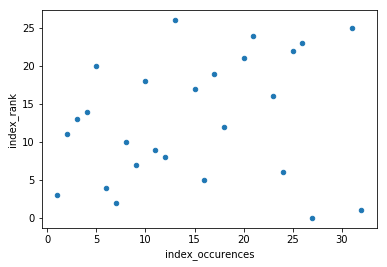

In [56]:
res.plot(kind='scatter', x='index_occurences', y='index_rank')

As you can see, it gives a pretty low correlation (0.2) so the number of universities in the top 200 for a country is weakly correlated with the average ranking by country.

This ends the notebook and the assigment.